In [4]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

somisettikusuma_houston_path = kagglehub.dataset_download('somisettikusuma/houston')
shreyadenre_best_topomorph_byip_keras_default_1_path = kagglehub.model_download('shreyadenre/best_topomorph_byip/Keras/default/1')

print('Data source import complete.')


  0%|          | 0.00/6.61M [00:00<?, ?B/s]
 15%|█▌        | 1.00M/6.61M [00:00<00:02, 2.67MB/s]
100%|██████████| 6.61M/6.61M [00:00<00:00, 12.0MB/s]

Data source import complete.


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houston/Houston13.mat
/kaggle/input/houston/Houston13_7gt.mat


In [7]:
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import time
from skimage.morphology import dilation, square
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, recall_score, jaccard_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, TimeDistributed, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
# Load the hyperspectral image
with h5py.File('/kaggle/input/houston/Houston13.mat', 'r') as f:
    print("Houston13 keys:", list(f.keys())) #['ori_data']
    # Assuming the dataset is stored under the first key
    data_key = list(f.keys())[0]
    data = np.array(f[data_key])
    # The data might need to be transposed depending on how it's stored
    data = data.transpose((2, 1, 0))  # shape: (height, width, bands)
    print("Loaded Houston13 data shape:", data.shape) #(210, 954, 48)

# Load the ground truth
with h5py.File('/kaggle/input/houston/Houston13_7gt.mat', 'r') as f:
    print("GT keys:", list(f.keys())) #['map']
    gt_key = list(f.keys())[0]
    gt = np.array(f[gt_key])
    gt = gt.transpose()  # shape: (height, width)
    print("Loaded Houston13 GT shape:", gt.shape) # (210, 954)

Houston13 keys: ['ori_data']
Loaded Houston13 data shape: (210, 954, 48)
GT keys: ['map']
Loaded Houston13 GT shape: (210, 954)


In [9]:
# 2. MSBI band selection
def msbi_band_selection(data, gt, top_k=30):
    height, width, bands = data.shape
    scores = []
    for b in range(bands):
        band_img = data[:, :, b]
        saliency = np.abs(band_img - dilation(band_img, square(3)))
        score = np.sum(saliency[gt > 0]) / np.sum(gt > 0)
        scores.append(score)
    top_indices = np.argsort(scores)[-top_k:]
    return top_indices

selected_bands = msbi_band_selection(data, gt, top_k=30)
data_selected = data[:, :, selected_bands]
print("Selected bands:", selected_bands) # [13 14 15 37 16 22 20 18 17 23 19 21 24 43 25 44 45 46 47 31 32 36 35 34 33 27 30 26 29 28]
print("Selected shape:", data_selected.shape) #(210, 954, 30)

# 3. MinMax scaling
scaler = MinMaxScaler()
reshaped = data_selected.reshape(-1, data_selected.shape[-1])
data_scaled = scaler.fit_transform(reshaped).reshape(data_selected.shape)

/tmp/ipython-input-3998979235.py:7: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  saliency = np.abs(band_img - dilation(band_img, square(3)))


Selected bands: [13 14 15 37 16 22 20 18 17 23 19 21 24 43 25 44 45 46 47 31 32 36 35 34
 33 27 30 26 29 28]
Selected shape: (210, 954, 30)


In [10]:
# Parameters
PATCH_SIZE = 13
pad_width = PATCH_SIZE // 2
NUM_CLASSES = len(np.unique(gt)) - 1  # Exclude background (0)

# Pad data and GT
data_padded = np.pad(data_selected, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='reflect')
gt_padded = np.pad(gt, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Extract valid patch positions (exclude background)
positions = np.argwhere(gt > 0)
X_patches = []
y_labels = []

for row, col in positions:
    patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
    X_patches.append(patch)
    y_labels.append(gt[row, col])

X = np.array(X_patches)
y = np.array(y_labels).reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_cat = encoder.fit_transform(y)

# Split
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, y_train_cat.shape) #(2024, 13, 13, 30) (2024, 7)
print("Test shape:", X_test.shape, y_test_cat.shape) #(506, 13, 13, 30) (506, 7)

Train shape: (2024, 13, 13, 30) (2024, 7)
Test shape: (506, 13, 13, 30) (506, 7)


### Compute Topological Features (patch-wise variance)

In [11]:
def compute_persistence_entropy(patch):
    flat_patch = patch.reshape(-1, patch.shape[-1])
    entropy = np.var(flat_patch, axis=0)
    return entropy

X_train_topo = np.array([compute_persistence_entropy(p) for p in X_train]) #(2024, 30)
X_test_topo = np.array([compute_persistence_entropy(p) for p in X_test]) #(506, 30)
print("Topological feature shape:", X_train_topo.shape, X_test_topo.shape)

Topological feature shape: (2024, 30) (506, 30)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
model_path = "/content/drive/MyDrive/Colab Notebooks/best_topomorph.h5"

In [16]:
old_model = load_model(model_path)
#old_model.summary()

In [ ]:
'''print(X_train.shape)       # (2024, 13, 13, 30)
print(X_train_topo.shape)  # (2024, 30)
print(y_train_cat.shape)   # (2024, 7)
print(X_test.shape)   # (506, 13, 13, 30)
print(X_test_topo.shape)   # (506, 30)'''

'print(X_train.shape)       # (2024, 13, 13, 30)\nprint(X_train_topo.shape)  # (2024, 30)\nprint(y_train_cat.shape)   # (2024, 7)\nprint(X_test.shape)   # (506, 13, 13, 30)\nprint(X_test_topo.shape)   # (506, 30)'

In [17]:
unique_classes = np.unique(gt)

In [18]:
classes = np.unique(gt)
classes = classes[classes > 0]  # remove background (usually label 0)
num_classes = len(classes)

print("Number of classes:", num_classes)
print("Class IDs:", classes)

Number of classes: 7
Class IDs: [1. 2. 3. 4. 5. 6. 7.]


In [ ]:
'''import matplotlib.pyplot as plt
labels = data
classes, counts = np.unique(labels[labels > 0], return_counts=True)
for cls, count in zip(classes, counts):
    print(f"Class {int(cls)}: {count} pixels")'''

'import matplotlib.pyplot as plt\nlabels = data\nclasses, counts = np.unique(labels[labels > 0], return_counts=True)\nfor cls, count in zip(classes, counts):\n    print(f"Class {int(cls)}: {count} pixels")'

In [ ]:
print("Unique class labels :", unique_classes) #[0. 1. 2. 3. 4. 5. 6. 7.]
print("Number of classes (excluding background 0):", len(unique_classes) - (1 if 0 in unique_classes else 0)) # 7
print("Old output layer:", old_model.layers[-1])
print("Units:", old_model.layers[-1].units)
print("Activation:", old_model.layers[-1].activation)

Unique class labels : [0. 1. 2. 3. 4. 5. 6. 7.]
Number of classes (excluding background 0): 7
Old output layer: <Dense name=dense_1, built=True>
Units: 16
Activation: <function softmax at 0x7e33204ae3e0>


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import clone_model

# Get outputs from all layers except the last Dense layer
base_input = old_model.input[0]  # spatial input
topo_input = old_model.input[1]  # topo input
x = old_model.layers[-2].output  # this is Dense(16) input

# New classification layer for 7 classes
new_output = Dense(7, activation='softmax')(x)

# New model
new_model = Model(inputs=[base_input, topo_input], outputs=new_output)

In [ ]:
'''for i, layer in enumerate(old_model.layers):
    try:
        print(f"{i:2d} | {layer.name:30s} | Output shape: {layer.output.shape}")
    except:
        print(f"{i:2d} | {layer.name:30s} | Output shape: N/A (InputLayer or unsupported)")'''

'for i, layer in enumerate(old_model.layers):\n    try:\n        print(f"{i:2d} | {layer.name:30s} | Output shape: {layer.output.shape}")\n    except:\n        print(f"{i:2d} | {layer.name:30s} | Output shape: N/A (InputLayer or unsupported)")'

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Get inputs
spatial_input = old_model.input[0]  # (None, 13, 13, 30)
topo_input = old_model.input[1]     # (None, 1) or (None, 30)
print("spatial_input",spatial_input.shape)
print("topo_input",topo_input.shape)
# Use correct intermediate output from global_average_pooling2d (layer 22)
intermediate_output = old_model.layers[22].output  # (None, 64)
print("intermediate_output",intermediate_output.shape)
# New classifier head
new_output = Dense(7, activation='softmax')(intermediate_output)
print("new_output",new_output.shape)

# New model
new_model = Model(inputs=[spatial_input, topo_input], outputs=new_output)

# Compile
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#new_model.summary()

spatial_input (None, 13, 13, 30)
topo_input (None, 1)
intermediate_output (None, 64)
new_output (None, 7)


In [21]:
history = new_model.fit(
    [X_train, X_train_topo],
    y_train_cat,
    validation_data=([X_test, X_test_topo], y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3092 - loss: 1.5995 - val_accuracy: 0.7569 - val_loss: 0.6385
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8175 - loss: 0.4436 - val_accuracy: 0.8992 - val_loss: 0.2364
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9038 - loss: 0.2126 - val_accuracy: 0.8854 - val_loss: 0.3099
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8966 - loss: 0.2237 - val_accuracy: 0.9130 - val_loss: 0.1725
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9389 - loss: 0.1489 - val_accuracy: 0.9348 - val_loss: 0.1794
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9562 - loss: 0.1080 - val_accuracy: 0.9387 - val_loss: 0.1508
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9398 - loss: 0.1608 - val_accuracy: 0.8281 - val_loss: 0.3993
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9300 - loss: 0.1905 - val_accuracy: 0.9625 

In [22]:
loss, acc = new_model.evaluate([X_test, X_test_topo], y_test_cat)
print(f"✅ Houston13 Test Accuracy: {acc*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.0558 
✅ Houston13 Test Accuracy: 99.80%


In [23]:
new_model.save('houston_model.h5')

In [52]:
new_model

<Functional name=functional_1, built=True>

In [24]:
results = {}
pred_labels = {}

In [25]:
# --- Utility Functions ---
def evaluate_model(y_true, y_pred, name):
    oa = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cls_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    aa = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    kappa = cohen_kappa_score(y_true, y_pred)
    miou = np.mean([
        cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        if (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i]) != 0 else 0
        for i in range(len(np.unique(y_true)))
    ])
    return {
        'OA': oa, 'AA': aa, 'Kappa': kappa, 'F1_per_class': f1_per_class, 'mIoU': miou
    }

def reconstruct_from_test_preds(preds_1d, test_indices, height, width):
    pred_map = np.zeros(height * width, dtype=np.uint8)
    pred_map[test_indices] = preds_1d + 1  # +1 to match GT labels
    return pred_map.reshape(height, width)

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     1.0000    0.9863    0.9931        73
           2     1.0000    1.0000    1.0000        73
           3     1.0000    1.0000    1.0000        57
           4     0.9846    1.0000    0.9922        64
           5     1.0000    1.0000    1.0000        81
           6     1.0000    1.0000    1.0000        89

    accuracy                         0.9980       506
   macro avg     0.9978    0.9980    0.9979       506
weighted avg     0.9981    0.9980    0.9980       506



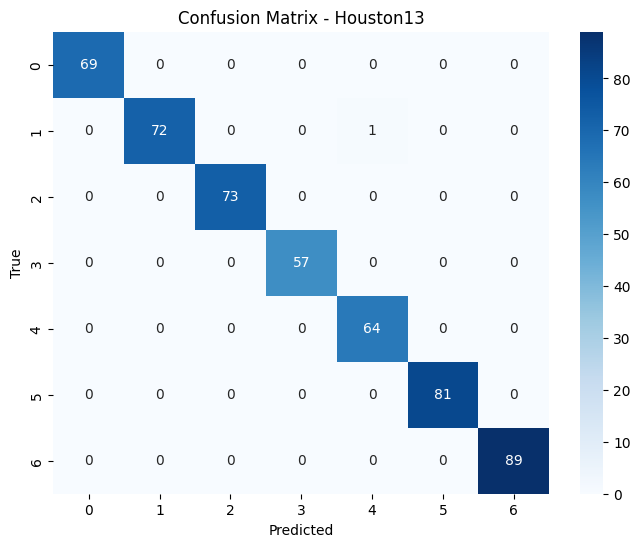

✅ Metrics on Houston13:
Overall Accuracy (OA): 99.80%
Average Accuracy (AA): 99.80%
Macro F1-score: 0.9979
Mean IoU (mIoU): 0.9958
Cohen's Kappa: 0.9977
Per-Class F1-scores: [1.         0.99310345 1.         1.         0.99224806 1.
 1.        ]
Per-Class Recall: [1.         0.98630137 1.         1.         1.         1.
 1.        ]


In [26]:
y_pred_probs = new_model.predict([X_test, X_test_topo], verbose=0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, digits=4))
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Houston13")
plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, jaccard_score

oa = accuracy_score(y_true_labels, y_pred_labels)
recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None)
aa = np.mean(recall_per_class)
f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_per_class = f1_score(y_true_labels, y_pred_labels, average=None)
miou = jaccard_score(y_true_labels, y_pred_labels, average='macro')
kappa = cohen_kappa_score(y_true_labels, y_pred_labels)

# Print everything
print(f"✅ Metrics on Houston13:")
print(f"Overall Accuracy (OA): {oa*100:.2f}%")
print(f"Average Accuracy (AA): {aa*100:.2f}%")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Mean IoU (mIoU): {miou:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Per-Class F1-scores: {f1_per_class}")
print(f"Per-Class Recall: {recall_per_class}")

In [27]:
precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
recall_macro = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

results['Proposed'] = {
    'OA': oa,
    'AA': aa,
    'Precision': precision_macro,
    'Recall': recall_macro,
    'F1': f1_macro,
    'Kappa': kappa,
    'mIoU': miou,
    'F1_per_class': f1_per_class
}
pred_labels['Proposed'] = y_pred_labels

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, cohen_kappa_score, jaccard_score

def evaluate_model(y_true, y_pred, name=''):
    oa = accuracy_score(y_true, y_pred)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    aa = np.mean(recall_per_class)

    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    miou = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    return {
        'OA': oa,
        'AA': aa,
        'Precision': precision_macro,
        'Recall': recall_macro,
        'F1': f1_macro,
        'Kappa': kappa,
        'mIoU': miou,
        'F1_per_class': f1_per_class,
        'Precision_per_class': precision_per_class,
        'Recall_per_class': recall_per_class
    }

In [29]:
#reusable
y_train_cls = np.argmax(y_train_cat, axis=1)
y_test_cls = np.argmax(y_test_cat, axis=1)
NUM_CLASSES = y_train_cat.shape[1]

In [30]:
# 1. SVM on Topological Features
svm = SVC()
svm.fit(X_train_topo, y_train_cls)
svm_preds = svm.predict(X_test_topo)
results['SVM'] = evaluate_model(y_test_cls, svm_preds, 'SVM')
pred_labels['SVM'] = svm_preds

In [31]:
# 2. KNN on Topological Features
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_topo, y_train_cls)
knn_preds = knn.predict(X_test_topo)
results['KNN'] = evaluate_model(y_test_cls, knn_preds, 'KNN')
pred_labels['SVM'] = knn_preds

In [32]:
# 3. CNN on Spatial Patches
cnn = Sequential([
    Input(shape=(13,13,30)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
cnn_preds = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
results['CNN'] = evaluate_model(y_test_cls, cnn_preds, 'CNN')
pred_labels['CNN'] = cnn_preds

In [33]:
# 4. CNN Encoder Variant
cnn_enc = Sequential([
    Input(shape=(13,13,30)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_enc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_enc.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
cnn_enc_preds = np.argmax(cnn_enc.predict(X_test, verbose=0), axis=1)
results['CNN_Encoder'] = evaluate_model(y_test_cls, cnn_enc_preds, 'CNN_Encoder')
pred_labels['CNN_Encoder'] = cnn_enc_preds

In [34]:
# 5. RNN on Band Sequences (reshape to sequences)
X_train_rnn = X_train.reshape((-1, 13*13, 30))  # (N, T, F)
X_test_rnn = X_test.reshape((-1, 13*13, 30))
rnn_input = Input(shape=(169, 30))
x = LSTM(64, return_sequences=False)(rnn_input)
x = Dense(32, activation='relu')(x)
rnn_output = Dense(NUM_CLASSES, activation='softmax')(x)
rnn_model = Model(rnn_input, rnn_output)
rnn_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=0)
rnn_preds = np.argmax(rnn_model.predict(X_test_rnn, verbose=0), axis=1)
results['RNN'] = evaluate_model(y_test_cls, rnn_preds, 'RNN')
pred_labels['RNN'] = rnn_preds

In [35]:
# 6. GTFN — A Simple Transformer-like Linear Projection
gtfn_input = Input(shape=(13,13,30))
x = Conv2D(64, (3,3), activation='relu', padding='same')(gtfn_input)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)
gtfn_model = Model(gtfn_input, x)
gtfn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gtfn_model.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
gtfn_preds = np.argmax(gtfn_model.predict(X_test, verbose=0), axis=1)
results['GTFN'] = evaluate_model(y_test_cls, gtfn_preds, 'GTFN')
pred_labels['GTFN'] = gtfn_preds

In [36]:
# 📊 Print Final Results Summary
class_names = [f'Class {i+1}' for i in range(NUM_CLASSES)]

for model_name, metrics in results.items():
    print(f"\n📊 F1-Score per Class for {model_name}:")
    for cls_name, f1_val in zip(class_names, metrics['F1_per_class']):
        print(f"{cls_name}: {f1_val:.4f}")


📊 F1-Score per Class for Proposed:
Class 1: 1.0000
Class 2: 0.9931
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
Class 7: 1.0000

📊 F1-Score per Class for SVM:
Class 1: 0.1333
Class 2: 0.4900
Class 3: 0.3459
Class 4: 0.8036
Class 5: 0.6184
Class 6: 0.4882
Class 7: 0.6479

📊 F1-Score per Class for KNN:
Class 1: 0.8550
Class 2: 0.8571
Class 3: 0.8000
Class 4: 0.9189
Class 5: 0.9104
Class 6: 0.8917
Class 7: 0.8542

📊 F1-Score per Class for CNN:
Class 1: 1.0000
Class 2: 0.9931
Class 3: 1.0000
Class 4: 0.9912
Class 5: 0.9922
Class 6: 1.0000
Class 7: 0.9944

📊 F1-Score per Class for CNN_Encoder:
Class 1: 0.9718
Class 2: 0.9645
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
Class 7: 1.0000

📊 F1-Score per Class for RNN:
Class 1: 0.0000
Class 2: 0.4232
Class 3: 0.0000
Class 4: 0.1538
Class 5: 0.0548
Class 6: 0.5488
Class 7: 0.2674

📊 F1-Score per Class for GTFN:
Class 1: 1.0000
Class 2: 0.9931
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
C

In [37]:
# Step 1: Extract all topo features for full dataset
topo_features = np.array([compute_persistence_entropy(p) for p in X_patches])
y_cls = y.flatten() - 1  # Shift labels to 0-based for sklearn models if needed

# Step 2: Evaluation loop
percentages = [0.30, 0.50, 0.70, 0.80, 0.90]
results_by_percent = {}

for pct in percentages:
    print(f"\nEvaluating for {int(pct*100)}% training data...")

    # Split data
    X_train_sp, X_test_sp, X_train_topo, X_test_topo, y_train_cls, y_test_cls = train_test_split(
        X_patches, topo_features, y_cls, test_size=(1 - pct), stratify=y_cls, random_state=42
    )

    y_train_cat = encoder.fit_transform(y_train_cls.reshape(-1, 1))
    y_test_cat = encoder.transform(y_test_cls.reshape(-1, 1))

    # Prepare models
    results_pct = {}
    pred_labels_pct = {}


    X_train_sp_np = np.array(X_train_sp)
    X_test_sp_np = np.array(X_test_sp)

    # Train Proposed Model
    new_model.fit([X_train_sp_np, X_train_topo], y_train_cat, epochs=15, batch_size=32, verbose=0)

    # Predict
    y_pred_probs = new_model.predict([X_test_sp_np, X_test_topo], verbose=0)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_cat, axis=1)
    oa = accuracy_score(y_true_labels, y_pred_labels)
    recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
    aa = np.mean(recall_per_class)
    f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    f1_per_class = f1_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
    miou = jaccard_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true_labels, y_pred_labels)
    precision_per_class = precision_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
    recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None, zero_division=0)

# Save results
    results_pct["Proposed"] = {
        "OA": oa,
        "AA": aa,
        "Kappa": kappa,
        "F1": f1_macro,
        "mIoU": miou,
        "F1_per_class": f1_per_class,
        "Precision_per_class": precision_per_class,
        "Recall_per_class": recall_per_class
    }
    pred_labels_pct["Proposed"] = y_pred_labels
    # SVM
    svm.fit(X_train_topo, y_train_cls)
    svm_preds = svm.predict(X_test_topo)
    results_pct["SVM"] = evaluate_model(y_test_cls, svm_preds)
    pred_labels_pct["SVM"] = svm_preds

    # KNN
    knn.fit(X_train_topo, y_train_cls)
    knn_preds = knn.predict(X_test_topo)
    results_pct["KNN"] = evaluate_model(y_test_cls, knn_preds)
    pred_labels_pct["KNN"] = knn_preds

    # CNN (spatial)
    cnn.fit(np.array(X_train_sp), y_train_cat, epochs=15, batch_size=32, verbose=0)
    cnn_preds = np.argmax(cnn.predict(np.array(X_test_sp), verbose=0), axis=1)
    results_pct["CNN"] = evaluate_model(y_test_cls, cnn_preds)
    pred_labels_pct["CNN"] = cnn_preds

    # CNN_Encoder
    cnn_enc.fit(np.array(X_train_sp), y_train_cat, epochs=15, batch_size=32, verbose=0)
    cnn_enc_preds = np.argmax(cnn_enc.predict(np.array(X_test_sp), verbose=0), axis=1)
    results_pct["CNN_Encoder"] = evaluate_model(y_test_cls, cnn_enc_preds)
    pred_labels_pct["CNN_Encoder"] = cnn_enc_preds

    # RNN
    X_patches = np.array(X_patches)  # Ensure it's a NumPy array
    X_train_rnn = np.array(X_train_sp).reshape((-1, PATCH_SIZE * PATCH_SIZE, X_patches.shape[-1]))
    X_test_rnn = np.array(X_test_sp).reshape((-1, PATCH_SIZE * PATCH_SIZE, X_patches.shape[-1]))
    rnn_model.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=0)
    rnn_preds = np.argmax(rnn_model.predict(X_test_rnn, verbose=0), axis=1)
    results['RNN'] = evaluate_model(y_test_cls, rnn_preds, 'RNN')

    X_train_sp_np = np.array(X_train_sp)
    X_test_sp_np = np.array(X_test_sp)

    gtfn_model.fit(X_train_sp_np, y_train_cat, epochs=15, batch_size=32, verbose=0)
    gtfn_preds = np.argmax(gtfn_model.predict(X_test_sp_np, verbose=0), axis=1)
    results_pct["GTFN"] = evaluate_model(y_test_cls, gtfn_preds)
    pred_labels_pct["GTFN"] = gtfn_preds

    results_by_percent[f"{int(pct*100)}%"] = {
        model: {
            "OA": result["OA"],
            "AA": result["AA"],
            "Kappa": result["Kappa"],
            "F1": result["F1"],
            "mIoU": result["mIoU"],
            "F1_per_class": result["F1_per_class"],
            "Precision_per_class": result["Precision_per_class"],
            "Recall_per_class": result["Recall_per_class"]
        }
        for model, result in results_pct.items()
    }


Evaluating for 30% training data...

Evaluating for 50% training data...

Evaluating for 70% training data...

Evaluating for 80% training data...

Evaluating for 90% training data...


In [42]:
results

{'Proposed': {'OA': 0.9980237154150198,
  'AA': np.float64(0.9980430528375734),
  'Precision': 0.9978021978021978,
  'Recall': 0.9980430528375734,
  'F1': 0.9979073586130524,
  'Kappa': np.float64(0.9976873751708188),
  'mIoU': np.float64(0.9958452506397713),
  'F1_per_class': array([1.        , 0.99310345, 1.        , 1.        , 0.99224806,
         1.        , 1.        ])},
 'SVM': {'OA': 0.5316205533596838,
  'AA': np.float64(0.5343729672069432),
  'Precision': 0.597875831710632,
  'Recall': 0.5343729672069432,
  'F1': 0.5038952537874416,
  'Kappa': np.float64(0.45101216798967236),
  'mIoU': np.float64(0.3609095662535594),
  'F1_per_class': array([0.13333333, 0.49      , 0.34586466, 0.80357143, 0.61842105,
         0.48818898, 0.64788732]),
  'Precision_per_class': array([0.83333333, 0.38582677, 0.38333333, 0.81818182, 0.53409091,
         0.67391304, 0.55645161]),
  'Recall_per_class': array([0.07246377, 0.67123288, 0.31506849, 0.78947368, 0.734375  ,
         0.38271605, 0.77528

In [41]:
def evaluate_all_models(X, X_topo, y_cat, y, train_fraction):
    results = {}
    # Split based on the given percentage
    X_train, X_test, X_train_topo, X_test_topo, y_train_cat, y_test_cat, y_train_cls, y_test_cls = train_test_split(
        X, X_topo, y_cat, y, train_size=train_fraction, stratify=y, random_state=42)

    num_classes = y_cat.shape[1]

    # ---------- TopoMorph Model ----------
    topo_preds = np.argmax(new_model.predict([X_test, X_test_topo], verbose=0), axis=1)
    topo_true = np.argmax(y_test_cat, axis=1)
    results['Proposed'] = evaluate_model(topo_true, topo_preds)

    # ---------- SVM ----------
    svm = SVC(kernel='rbf')
    svm.fit(X_train_topo, y_train_cls)
    svm_preds = svm.predict(X_test_topo)
    results['SVM'] = evaluate_model(y_test_cls, svm_preds)

    # ---------- KNN ----------
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_topo, y_train_cls)
    knn_preds = knn.predict(X_test_topo)
    results['KNN'] = evaluate_model(y_test_cls, knn_preds)

    # ---------- CNN ----------
    cnn.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
    cnn_preds = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
    results['CNN'] = evaluate_model(y_test_cls, cnn_preds)

    # ---------- CNN Encoder ----------
    cnn_enc.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
    cnn_enc_preds = np.argmax(cnn_enc.predict(X_test, verbose=0), axis=1)
    results['CNN_Encoder'] = evaluate_model(y_test_cls, cnn_enc_preds)

    # ---------- RNN ----------
    X_train_rnn = X_train.reshape((-1, 13*13, 30))
    X_test_rnn = X_test.reshape((-1, 13*13, 30))
    rnn_model.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=0)
    rnn_preds = np.argmax(rnn_model.predict(X_test_rnn, verbose=0), axis=1)
    results['RNN'] = evaluate_model(y_test_cls, rnn_preds)

    # ---------- GTFN ----------
    gtfn_model.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
    gtfn_preds = np.argmax(gtfn_model.predict(X_test, verbose=0), axis=1)
    results['GTFN'] = evaluate_model(y_test_cls, gtfn_preds)

    return results

In [ ]:
percentages

[30, 50, 70, 80, 90]

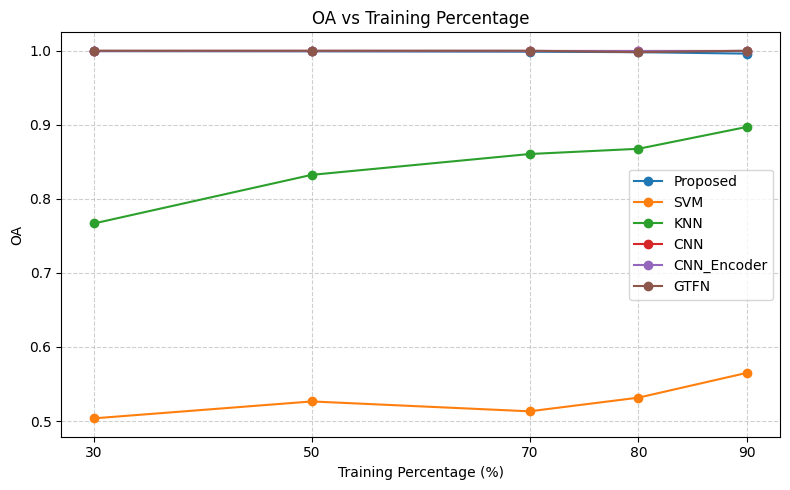

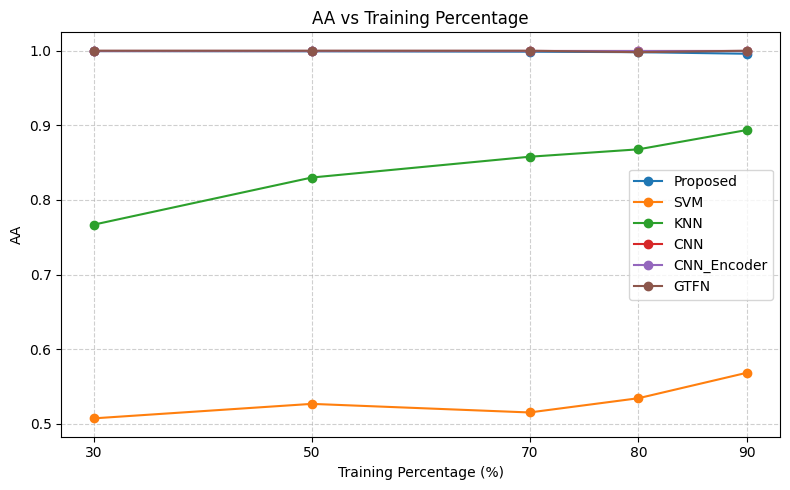

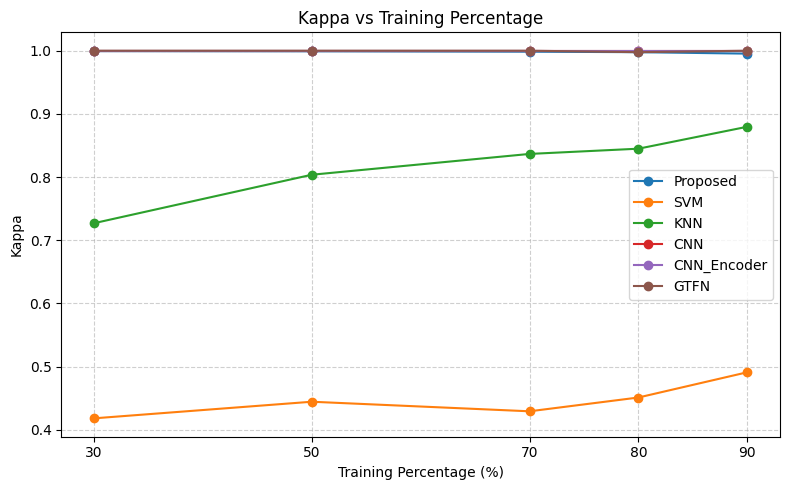

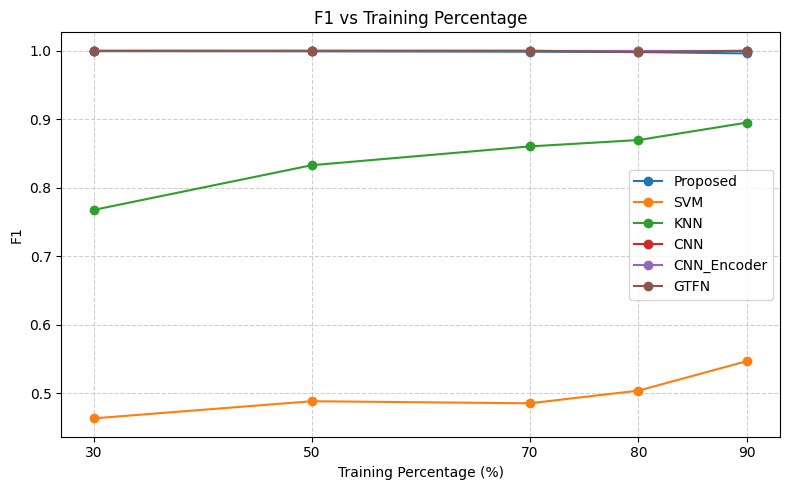

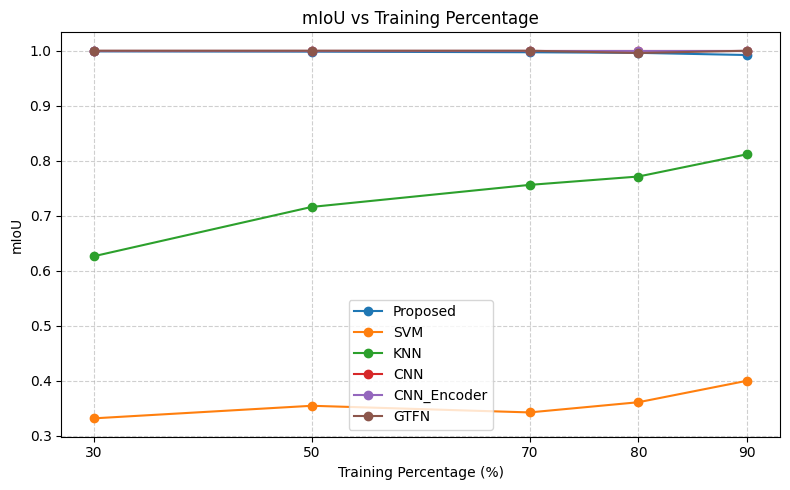

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics you want to plot
metrics_to_plot = ['OA', 'AA', 'Kappa', 'F1', 'mIoU']

# Extract all model names (assuming consistent across percentages)
model_names = list(next(iter(results_by_percent.values())).keys())

# Define percentages
percentages = [int(p.strip('%')) for p in results_by_percent.keys()]

# Plot each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for model in model_names:
        y_vals = [results_by_percent[f"{pct}%"][model][metric] for pct in percentages]
        plt.plot(percentages, y_vals, marker='o', label=model)

    plt.title(f'{metric} vs Training Percentage')
    plt.xlabel('Training Percentage (%)')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(percentages)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

# Create class label index
class_labels = [f'Class {i+1}' for i in range(len(next(iter(results.values()))['F1_per_class']))]
df = pd.DataFrame(index=class_labels)

# Fill in F1 scores
for model_name, metrics in results.items():
    df[model_name] = metrics['F1_per_class']

# Insert separator row
df.loc['──────────'] = [''] * len(df.columns)

# Insert overall scores
df.loc['OA'] = [results[m]['OA'] * 100 for m in df.columns]
df.loc['AA'] = [results[m]['AA'] * 100 for m in df.columns]
df.loc['Kappa'] = [results[m]['Kappa'] * 100 for m in df.columns]

# Round values
df = df.round(4)

# Move 'Proposed' to the end
columns = [c for c in df.columns if c != 'Proposed'] + ['Proposed']
df = df[columns]

# Add 'Class' column and reset index
df.insert(0, 'Class', df.index)
df = df.reset_index(drop=True)

# Highlight max values in each row (skip first column)
def highlight_max(row):
    if row['Class'] == '──────────':
        return [''] * len(row)
    try:
        vals = row[1:].astype(float)
        is_max = vals == vals.max()
        return [''] + ['font-weight: bold' if v else '' for v in is_max]
    except:
        return [''] * len(row)

# Apply style and display
styled_df = df.style.apply(highlight_max, axis=1)
styled_df.hide(axis="index")
display(styled_df)


Class,SVM,KNN,CNN,CNN_Encoder,RNN,GTFN,Proposed
Class 1,0.133333,0.854962,1.000000,1.000000,1.000000,1.000000,1.000000
Class 2,0.490000,0.857143,0.993103,0.993103,1.000000,0.993103,0.993103
Class 3,0.345865,0.800000,1.000000,1.000000,1.000000,1.000000,0.993197
Class 4,0.803571,0.918919,1.000000,1.000000,0.981818,1.000000,1.000000
Class 5,0.618421,0.910448,0.992248,0.992248,1.000000,0.992248,1.000000
Class 6,0.488189,0.891720,1.000000,1.000000,0.987952,0.970060,1.000000
Class 7,0.647887,0.854167,1.000000,1.000000,0.977273,0.971098,1.000000
──────────,,,,,,,
OA,53.162055,86.758893,99.802372,99.802372,99.209486,98.814229,99.802372
AA,53.437297,86.787698,99.804305,99.804305,99.165121,99.001737,99.804305


## 3d f1 scores

/tmp/ipython-input-1735369020.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')  # Use a colormap with distinct colors
/tmp/ipython-input-1735369020.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


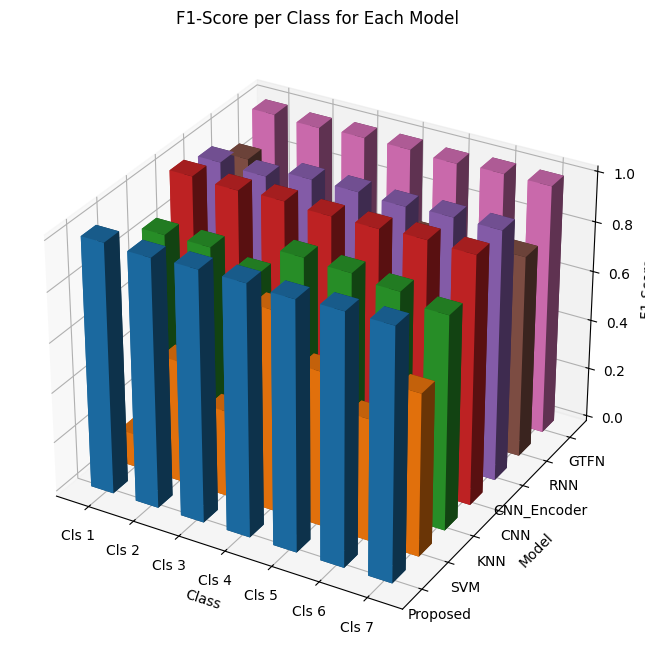

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
model_names = list(results.keys())
num_models = len(model_names)
num_classes = len(results[model_names[0]]['F1_per_class'])

xpos, ypos = np.meshgrid(np.arange(num_classes), np.arange(num_models))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = dy = 0.5
dz = np.array([
    results[model]['F1_per_class'][cls_idx]
    for model in model_names
    for cls_idx in range(num_classes)
])

# Assign a different color to each model
from matplotlib.cm import get_cmap
cmap = get_cmap('tab10')  # Use a colormap with distinct colors
colors = [cmap(i % 10) for i in range(num_models)]
bar_colors = [colors[y] for y in ypos]  # Color by model (ypos axis)

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color=bar_colors)

ax.set_xticks(np.arange(num_classes) + dx / 2)
ax.set_xticklabels([f'Cls {i+1}' for i in range(num_classes)])
ax.set_yticks(np.arange(num_models) + dy / 2)
ax.set_yticklabels(model_names)
ax.set_xlabel('Class')
ax.set_ylabel('Model')
ax.set_zlabel('F1 Score')
ax.set_title('F1-Score per Class for Each Model')
plt.tight_layout()
plt.show()

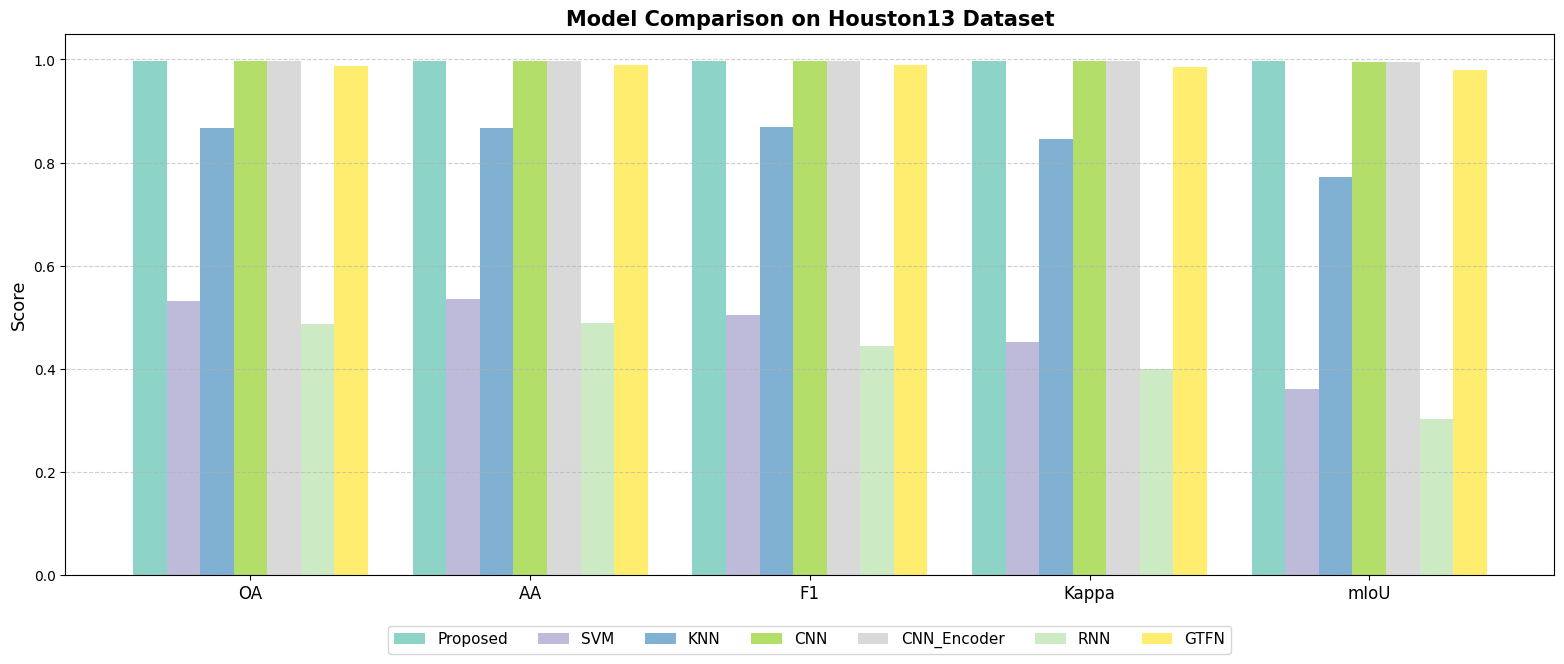

In [ ]:
import matplotlib.pyplot as plt

metrics_to_plot = ['OA', 'AA', 'F1', 'Kappa', 'mIoU']
model_names = list(results.keys())
num_models = len(model_names)
bar_width = 0.12
x = np.arange(len(metrics_to_plot))

# Custom color palette (optional)
colors = plt.cm.Set3(np.linspace(0, 1, num_models))

plt.figure(figsize=(16, 7))

for idx, model in enumerate(model_names):
    metric_vals = [results[model][metric] for metric in metrics_to_plot]
    plt.bar(x + idx * bar_width, metric_vals, width=bar_width, label=model, color=colors[idx])

# Center x-ticks
plt.xticks(x + bar_width * (num_models - 1) / 2, metrics_to_plot, fontsize=12)
plt.ylabel("Score", fontsize=13)
plt.title("Model Comparison on Houston13 Dataset", fontsize=15, fontweight='bold')

plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=num_models, fontsize=11)
plt.tight_layout(pad=2)
plt.show()

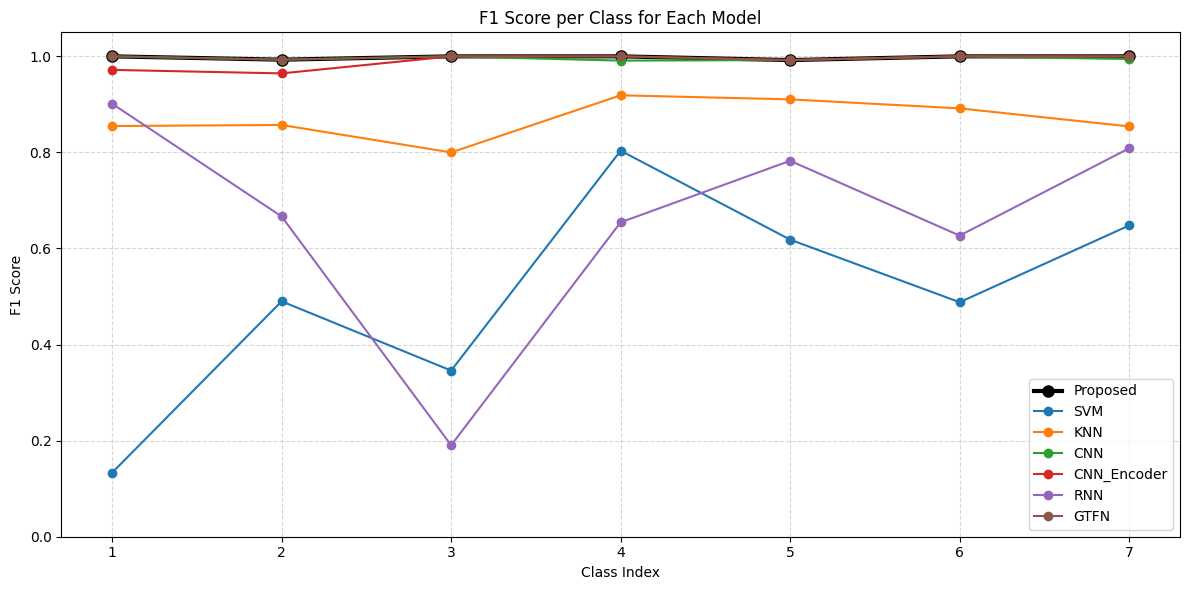

In [39]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))

class_indices = np.arange(1, 8)  # 7 classes

for model_name, metrics in results.items():
    if model_name.lower() == "proposed":  # or use exact match: model_name == "Proposed"
        plt.plot(class_indices, metrics['F1_per_class'], marker='o',
                 label=model_name, color='black', linewidth=3, markersize=8)
    else:
        plt.plot(class_indices, metrics['F1_per_class'], marker='o', label=model_name)

plt.xticks(class_indices)
plt.xlabel('Class Index')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class for Each Model')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

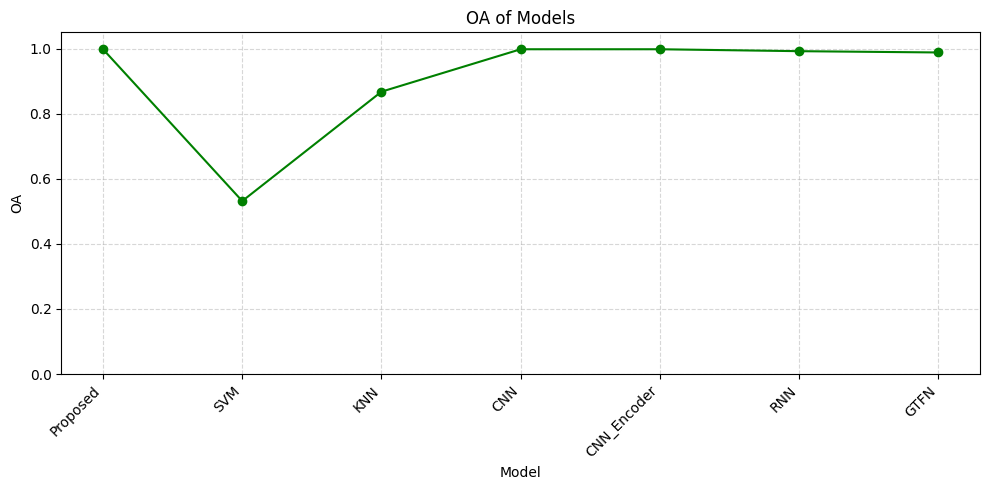

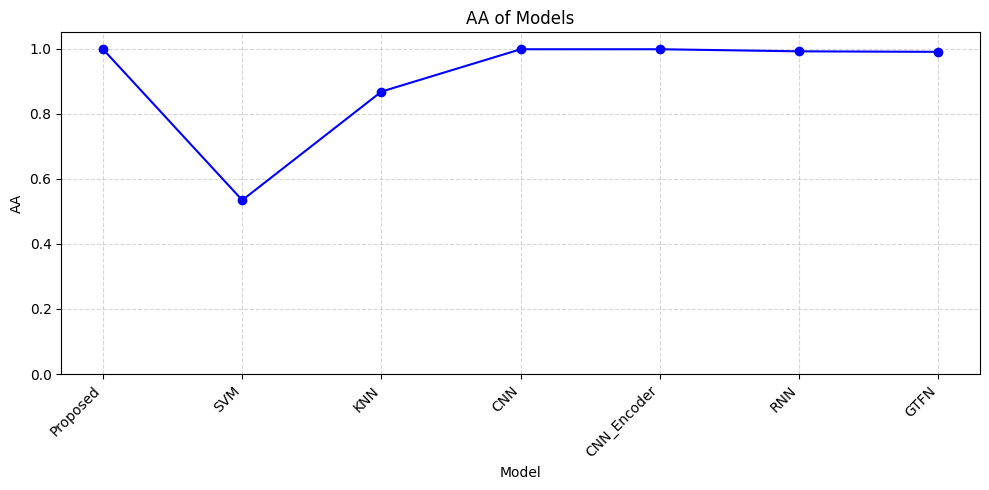

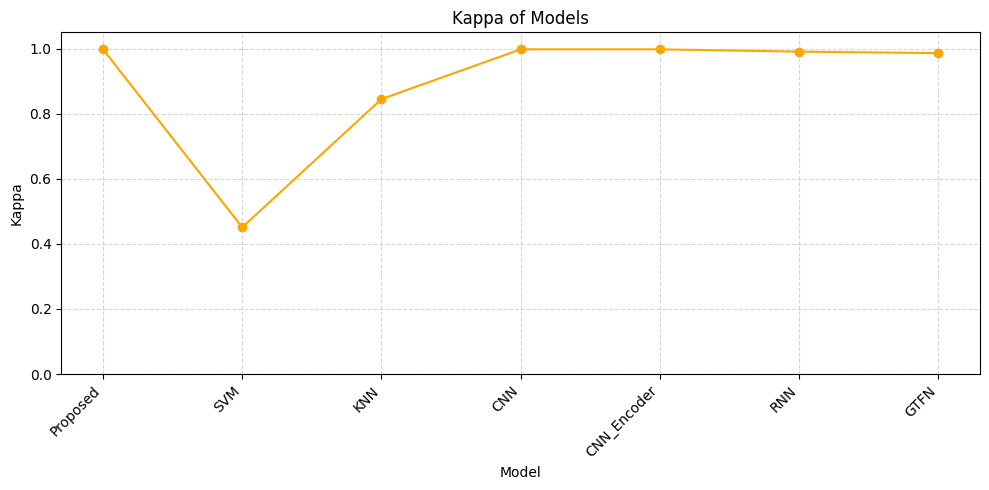

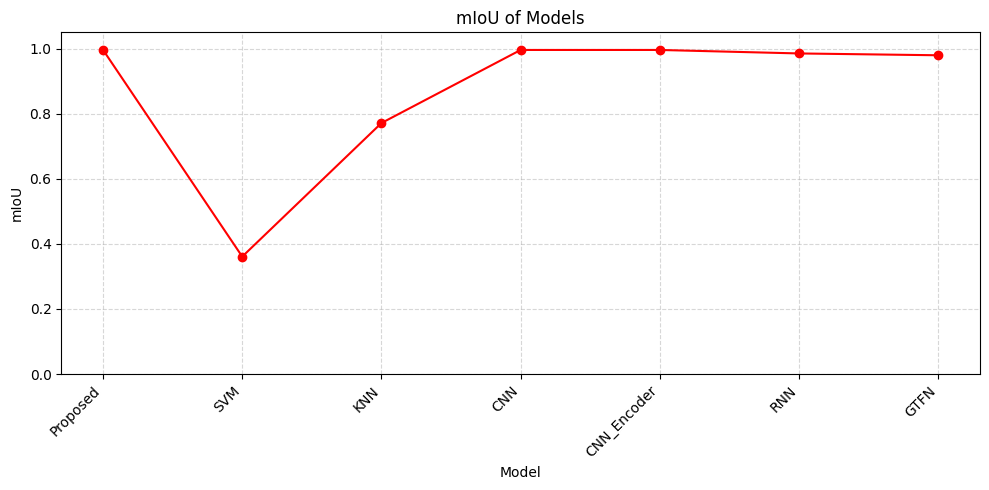

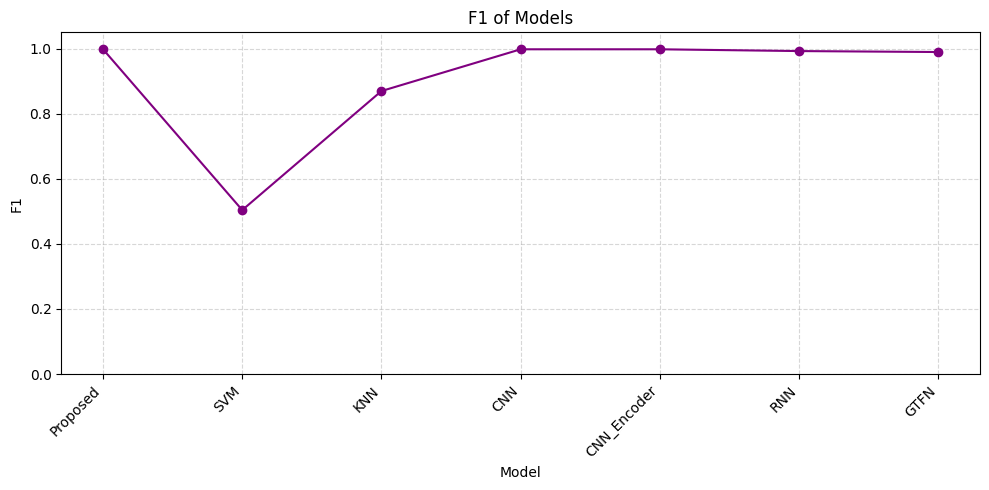

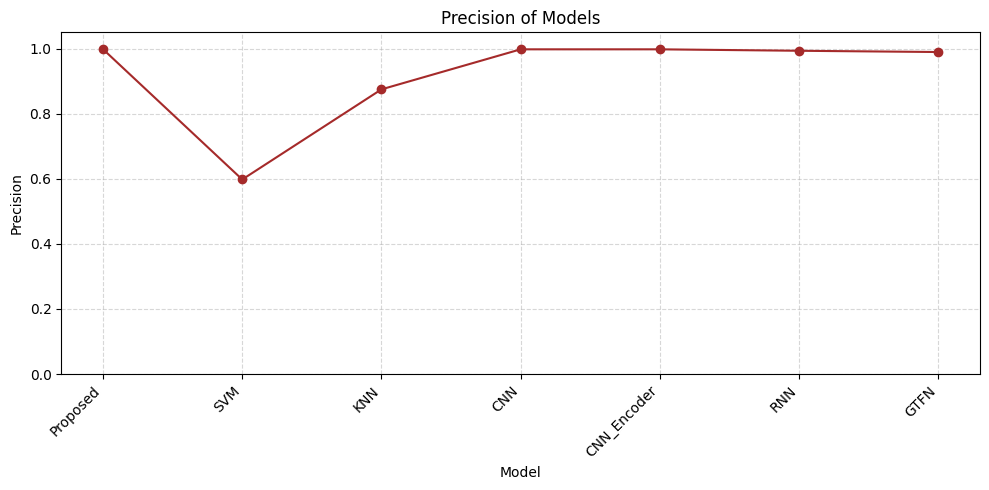

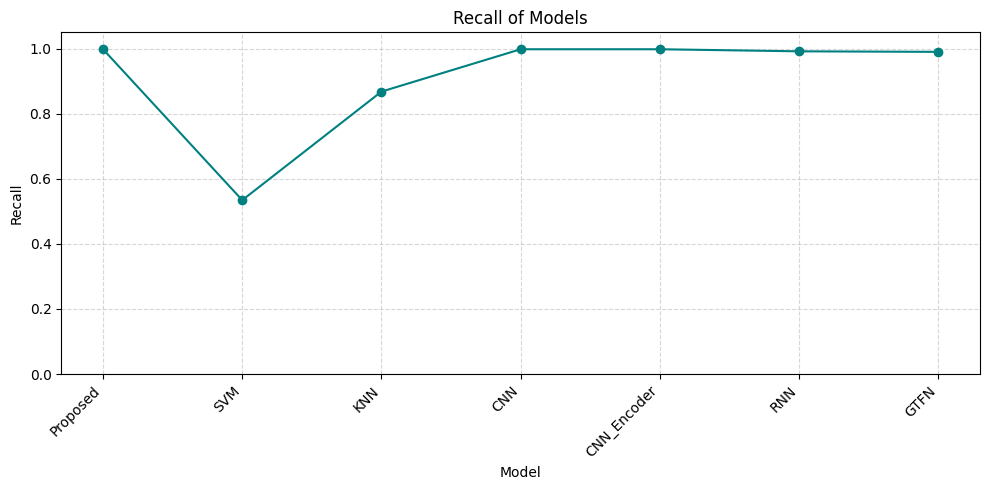

In [ ]:
metrics = ['OA', 'AA', 'Kappa', 'mIoU', 'F1','Precision','Recall']
colors = ['green', 'blue', 'orange', 'red', 'purple', 'brown', 'teal']  # Optional: customize if needed

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]

    plt.figure(figsize=(10, 5))
    plt.plot(list(results.keys()), values, marker='o', linestyle='-', color=colors[i % len(colors)])
    plt.ylim(0, 1.05)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} of Models')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
results

{'Proposed': {'OA': 0.9980237154150198,
  'AA': 0.9980430528375734,
  'Precision': 0.998069498069498,
  'Recall': 0.9980430528375734,
  'F1': 0.9980429610267753,
  'Kappa': 0.9976872800402212,
  'mIoU': 0.9961125509070714,
  'F1_per_class': array([1.        , 0.99310345, 0.99319728, 1.        , 1.        ,
         1.        , 1.        ])},
 'SVM': {'OA': 0.5316205533596838,
  'AA': 0.5343729672069432,
  'Precision': 0.597875831710632,
  'Recall': 0.5343729672069432,
  'F1': 0.5038952537874415,
  'Kappa': 0.45101216798967225,
  'mIoU': 0.3609095662535594,
  'F1_per_class': array([0.13333333, 0.49      , 0.34586466, 0.80357143, 0.61842105,
         0.48818898, 0.64788732]),
  'Precision_per_class': array([0.83333333, 0.38582677, 0.38333333, 0.81818182, 0.53409091,
         0.67391304, 0.55645161]),
  'Recall_per_class': array([0.07246377, 0.67123288, 0.31506849, 0.78947368, 0.734375  ,
         0.38271605, 0.7752809 ])},
 'KNN': {'OA': 0.8675889328063241,
  'AA': 0.8678769823965891,
  

In [43]:
def create_prediction_map(pred_labels, positions, shape):
    """
    pred_labels: predicted labels (N,)
    positions: array of (row, col) positions corresponding to each prediction
    shape: (height, width) of the original ground truth
    """
    pred_map = np.zeros(shape, dtype=np.uint8)
    for (r, c), label in zip(positions, pred_labels):
        pred_map[r, c] = label + 1  # +1 because your classes start from 1
    return pred_map


In [44]:
h, w = gt.shape
gt_map = gt  # Ground Truth map

model_maps = {}
for name, preds in pred_labels.items():
    model_maps[name] = create_prediction_map(preds, positions, (h, w))


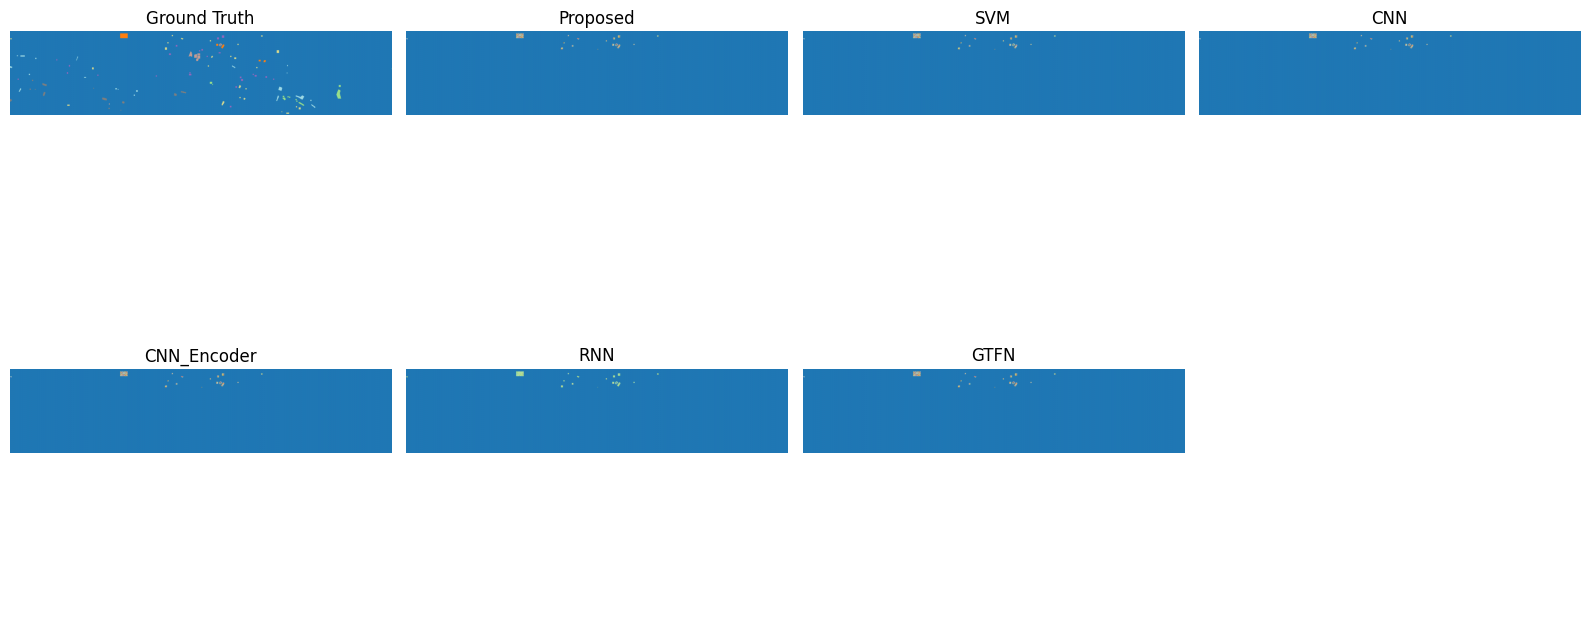

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

n_models = len(model_maps)
n_cols = 4
n_rows = int(np.ceil((n_models + 1) / n_cols))  # +1 for GT

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Get consistent color map
cmap = plt.get_cmap('tab20', NUM_CLASSES + 1)  # 0 (black) for background

# Plot GT
axes = axes.flatten()
axes[0].imshow(gt_map, cmap=cmap, norm=mcolors.BoundaryNorm(boundaries=np.arange(NUM_CLASSES+2)-0.5, ncolors=NUM_CLASSES+1))
axes[0].set_title("Ground Truth")
axes[0].axis('off')

# Plot each model
for i, (name, pred_map) in enumerate(model_maps.items(), start=1):
    axes[i].imshow(pred_map, cmap=cmap, norm=mcolors.BoundaryNorm(boundaries=np.arange(NUM_CLASSES+2)-0.5, ncolors=NUM_CLASSES+1))
    axes[i].set_title(name)
    axes[i].axis('off')

# Hide empty axes
for j in range(n_models + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [46]:
from matplotlib.cm import ScalarMappable

sm = ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=NUM_CLASSES))
fig.colorbar(sm, ax=axes.tolist(), fraction=0.015, pad=0.01, ticks=range(NUM_CLASSES+1), label='Class')

/tmp/ipython-input-4110414664.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


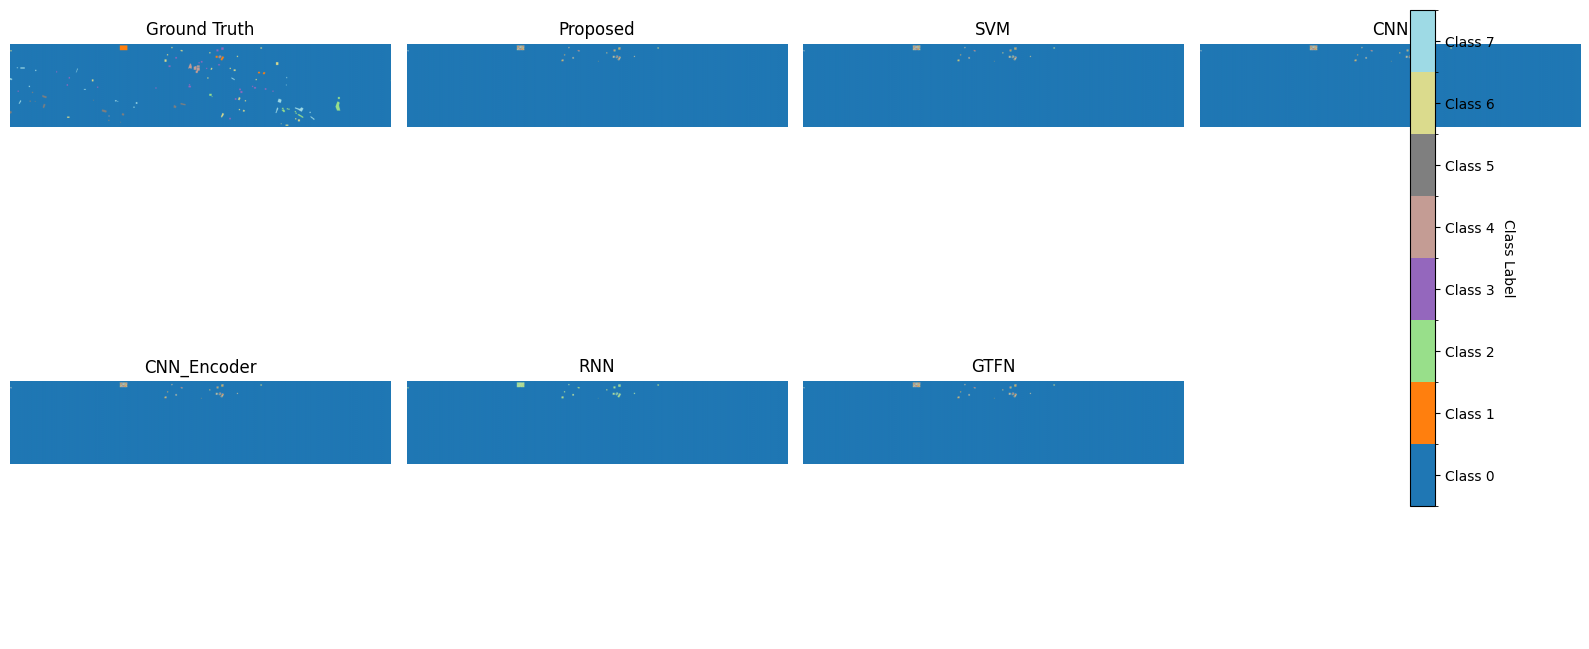

In [47]:
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

# Define color map with NUM_CLASSES + 1 (including background)
cmap = plt.get_cmap('tab20', NUM_CLASSES + 1)
norm = mcolors.BoundaryNorm(np.arange(NUM_CLASSES + 2) - 0.5, cmap.N)

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot GT
axes[0].imshow(gt_map, cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth")
axes[0].axis('off')

# Plot models
for i, (name, pred_map) in enumerate(model_maps.items(), start=1):
    axes[i].imshow(pred_map, cmap=cmap, norm=norm)
    axes[i].set_title(name)
    axes[i].axis('off')

# Hide extra axes
for j in range(len(model_maps) + 1, len(axes)):
    axes[j].axis('off')

# Add colorbar with class ticks
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.02, pad=0.01)
cbar.set_ticks(np.arange(0, NUM_CLASSES + 1))
cbar.set_ticklabels([f'Class {i}' for i in range(0, NUM_CLASSES + 1)])
cbar.ax.set_ylabel("Class Label", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [49]:
import matplotlib.pyplot as plt

def show_prediction_prob_map(prob_map, title, class_idx):
    """
    prob_map: numpy array of shape (H, W, C) or (H, W), softmax output per pixel
    class_idx: int, the class index to visualize
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(prob_map[:, :, class_idx], cmap='viridis')
    plt.colorbar(label=f"Probability of Class {class_idx}")
    plt.title(title)
    plt.axis('off')
    plt.show()


In [53]:
def create_prediction_probability_map(prob_vectors, positions, shape, num_classes):
    """Creates a prediction probability map (H, W, C) from flat prob vectors."""
    pred_map = np.zeros((shape[0], shape[1], num_classes), dtype=np.float32)
    for (r, c), probs in zip(positions, prob_vectors):
        pred_map[r, c, :] = probs
    return pred_map

In [57]:
NUM_CLASSES#gt.shape#positions.shape

7

In [62]:
y_pred_probs.shape

(253, 7)

In [64]:
prediction_maps = {}  # For storing softmax output maps

# PROPOSED MODEL
#topo_preds = np.argmax(new_model.predict([X_test, X_test_topo], verbose=0), axis=1)
#y_pred_probs = new_model.predict([X_test, X_test_topo], verbose=0)  # (N, C)
prediction_maps['Proposed'] = create_prediction_probability_map(
    y_pred_probs, positions, gt.shape, NUM_CLASSES
)

# CNN
cnn_probs = cnn.predict(X_test, verbose=0)
prediction_maps['CNN'] = create_prediction_probability_map(
    cnn_probs, positions, gt.shape, NUM_CLASSES
)

# CNN_Encoder
cnn_enc_probs = cnn_enc.predict(X_test, verbose=0)
prediction_maps['CNN_Encoder'] = create_prediction_probability_map(
    cnn_enc_probs, positions, gt.shape, NUM_CLASSES
)

# RNN
rnn_probs = rnn_model.predict(X_test_rnn, verbose=0)
prediction_maps['RNN'] = create_prediction_probability_map(
    rnn_probs, positions, gt.shape, NUM_CLASSES
)

# GTFN
gtfn_probs = gtfn_model.predict(X_test, verbose=0)
prediction_maps['GTFN'] = create_prediction_probability_map(
    gtfn_probs, positions, gt.shape, NUM_CLASSES
)
svm_probs = svm.predict_proba(X_test_topo)
prediction_maps['SVM'] = create_prediction_probability_map(
    svm_probs, positions, gt.shape, NUM_CLASSES
)
svm_probs = svm.predict_proba(X_test_topo)
prediction_maps['SVM'] = create_prediction_probability_map(
    svm_probs, positions, gt.shape, NUM_CLASSES
)


In [65]:
import matplotlib.pyplot as plt

def plot_prediction_prob_maps(prediction_maps, class_idx):
    n_models = len(prediction_maps)
    fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))

    for ax, (model_name, prob_map) in zip(axes, prediction_maps.items()):
        im = ax.imshow(prob_map[:, :, class_idx], cmap='viridis')
        ax.set_title(f"{model_name} (Class {class_idx})")
        ax.axis('off')
        fig.colorbar(im, ax=ax, shrink=0.7)

    plt.tight_layout()
    plt.show()


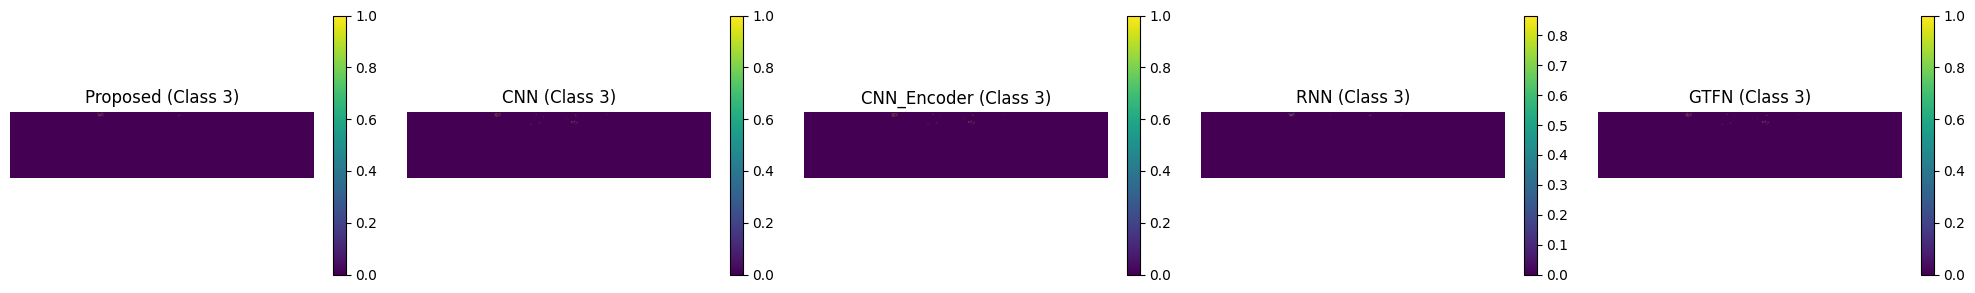

In [66]:
plot_prediction_prob_maps(prediction_maps, class_idx=3)  # or any class index


In [71]:
def create_prediction_probability_map(probs, positions, img_shape, num_classes):
    """Create a probability map from model predictions"""
    prob_map = np.zeros((img_shape[0], img_shape[1], num_classes))
    for idx, (i, j) in enumerate(positions):
        if idx < len(probs):  # Ensure we don't exceed prediction array
            prob_map[i, j] = probs[idx]
    return prob_map

def create_classification_map(labels, positions, img_shape):
    """Create a classification map from predicted labels"""
    cls_map = np.zeros(img_shape)
    for idx, (i, j) in enumerate(positions):
        cls_map[i, j] = labels[idx]
    return cls_map

In [70]:
# Ensure positions are within bounds
positions = np.argwhere(gt > 0)  # This should give you all non-zero GT positions
positions = [(i,j) for (i,j) in positions if i < gt.shape[0] and j < gt.shape[1]]

In [69]:
print("y_pred_probs shape:", y_pred_probs.shape)  # Should be (num_samples, num_classes)
print("Positions shape:", len(positions))        # Should match num_samples
print("GT shape:", gt.shape)

y_pred_probs shape: (253, 7)
Positions shape: 2530
GT shape: (210, 954)
